### **Getting data**

In [1]:
from data.data_loader import get_data
import tensorflow as tf

In [2]:
import warnings
warnings.filterwarnings('ignore')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [3]:
seed = 0
train_tensor, validation_tensor, test_tensor = get_data(seed=seed)

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

training_data = train_tensor.cache().shuffle(961).prefetch(buffer_size=AUTOTUNE)
validation_data = validation_tensor.cache().prefetch(buffer_size=AUTOTUNE)
test_data = test_tensor.cache().prefetch(buffer_size=AUTOTUNE)

### **Model training**

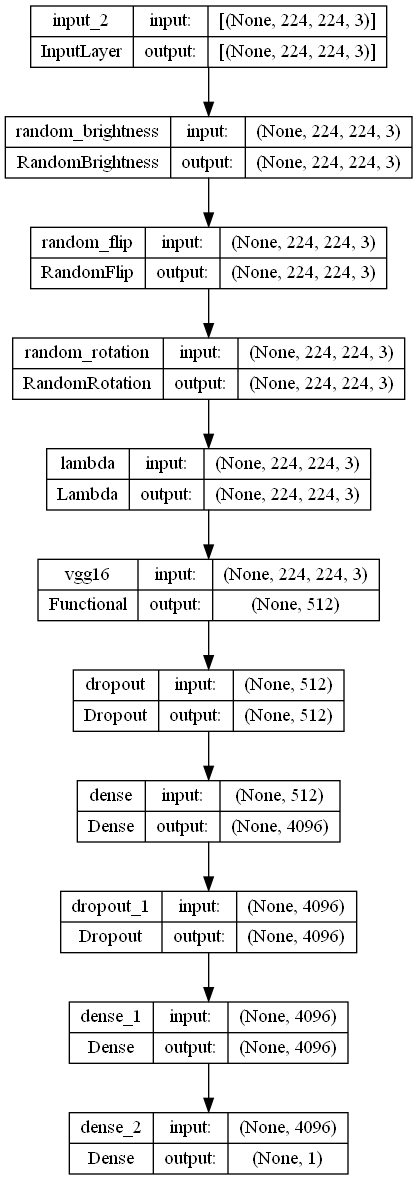

In [5]:
from vgg import VGG

model = VGG()
tf.keras.utils.plot_model(model.model, to_file='./raw_models/efficient_topology.png', show_shapes=True)

In [6]:
model.model.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_brightness (RandomBr  (None, 224, 224, 3)      0         
 ightness)                                                       
                                                                 
 random_flip (RandomFlip)    (None, 224, 224, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 224, 224, 3)      0         
 tion)                                                           
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dropout (Dropout)           (None, 512)               0     

In [7]:
model.fit(
    training_data,
    validation_data,
    learning_rate=0.01,
    patience=5,
    epochs=100,
    verbose=1
)

Epoch 1/100
36/36 [==============================] - 288s 8s/step - loss: 42.5235 - roc_auc: 0.5414 - binary_accuracy: 0.5569 - val_loss: 0.6318 - val_roc_auc: 0.7727 - val_binary_accuracy: 0.6918 - lr: 0.0100
Epoch 2/100
36/36 [==============================] - 259s 7s/step - loss: 0.7476 - roc_auc: 0.6752 - binary_accuracy: 0.6173 - val_loss: 0.5830 - val_roc_auc: 0.8426 - val_binary_accuracy: 0.7462 - lr: 0.0100
Epoch 3/100
36/36 [==============================] - 251s 7s/step - loss: 0.5354 - roc_auc: 0.8139 - binary_accuracy: 0.7432 - val_loss: 0.5512 - val_roc_auc: 0.8454 - val_binary_accuracy: 0.7583 - lr: 0.0100
Epoch 4/100
36/36 [==============================] - 251s 7s/step - loss: 0.5548 - roc_auc: 0.7969 - binary_accuracy: 0.7271 - val_loss: 0.5812 - val_roc_auc: 0.8507 - val_binary_accuracy: 0.6979 - lr: 0.0100
Epoch 5/100
36/36 [==============================] - 250s 7s/step - loss: 0.4991 - roc_auc: 0.8374 - binary_accuracy: 0.7714 - val_loss: 0.4950 - val_roc_auc: 0.85

In [8]:
model.save_model('vgg')

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...layers\functional
......vars
...layers\functional\layers\conv2d
......vars
.........0
.........1
...layers\functional\layers\conv2d_1
......vars
.........0
.........1
...layers\functional\layers\conv2d_10
......vars
.........0
.........1
...layers\functional\layers\conv2d_11
......vars
.........0
.........1
...layers\functional\layers\conv2d_12
......vars
.........0
.........1
...layers\functional\layers\conv2d_2
......vars
.........0
.........1
...layers\functional\layers\conv2d_3
......vars
.........0
.........1
...layers\functional\layers\conv2d_4
......vars
.........0
.........1
...layers\functional\layers\conv2d_5
......vars
.........0
.........1
...layers\functional\layers\conv2d_6
......vars
.........0
.

### **Model evaluation**

In [9]:
y_true, y_pred = model.predict(test_data)

In [10]:
import numpy as np

y_probas_efficient = np.column_stack((1 - y_pred, y_pred))

In [11]:
from plots import plot_target_vs_score

In [12]:
plot_target_vs_score(y_true, y_pred, quantiles=10)

In [13]:
plot_target_vs_score(y_true, y_pred, quantiles=100, lower_limit=90)

In [14]:
loss, auc, accuracy = model.evaluate(test_data, verbose=1)
loss, auc, accuracy

42/42 [==============================] - 237s 6s/step - loss: 0.4982 - roc_auc: 0.8370 - binary_accuracy: 0.8019


(0.4981788098812103, 0.8369739055633545, 0.8019113540649414)

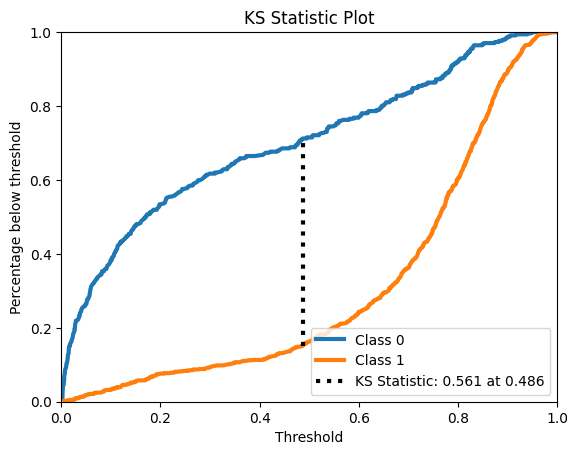

In [15]:
import scikitplot as skplt
import matplotlib.pyplot as plt

skplt.metrics.plot_ks_statistic(y_true=y_true, y_probas=y_probas_efficient)
plt.show()

In [16]:
from sklearn import metrics

results = [(labels, model.model.predict(images).reshape(-1)) for images, labels in test_data.take(-1)]

1/1 [==============================] - 1s 581ms/step


##### Other metrics

In [17]:
labels = np.concatenate([x[0] for x in results])
preds = np.concatenate([x[1] for x in results])

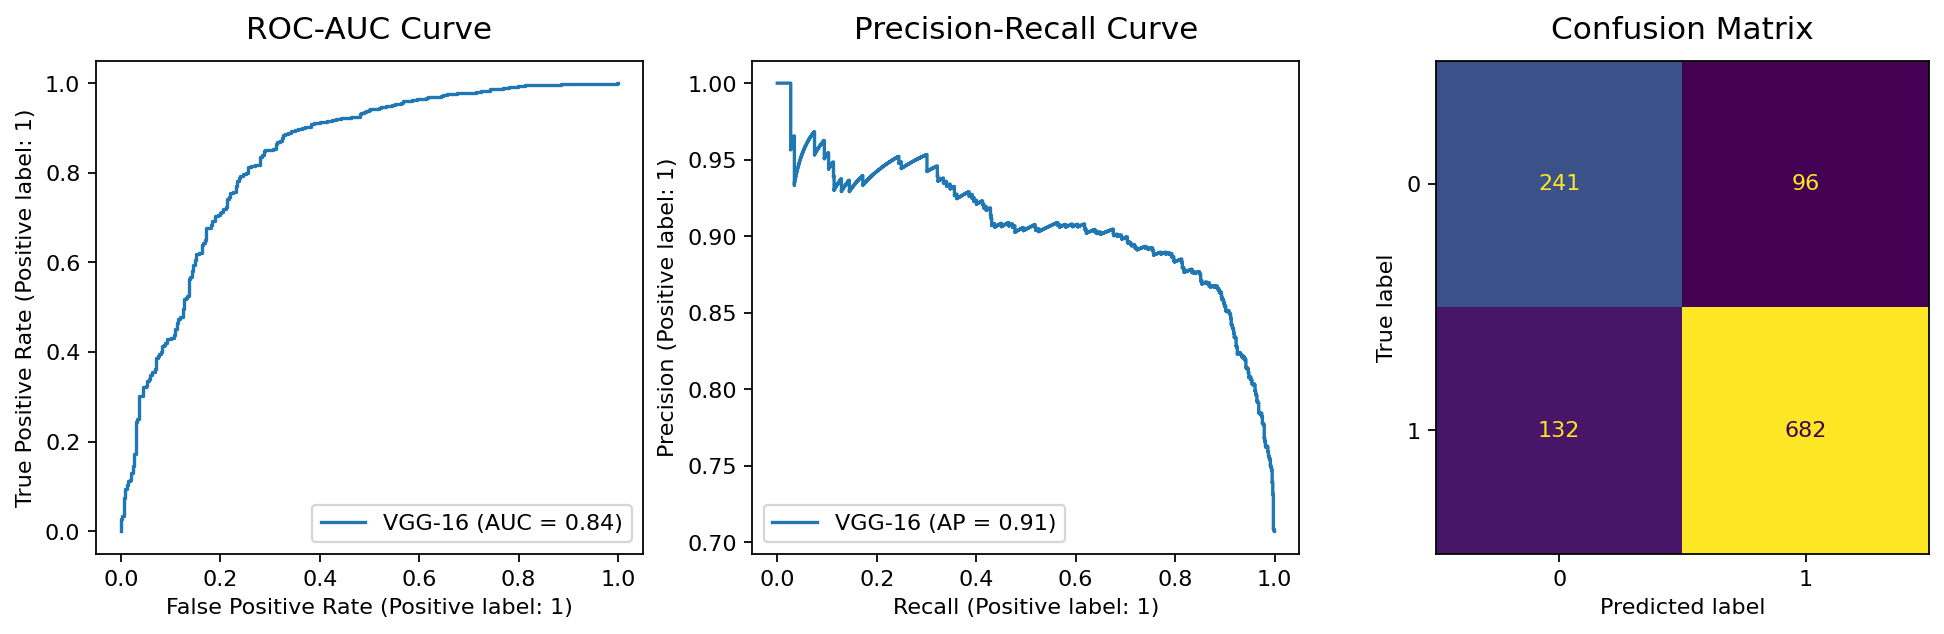

In [18]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4), dpi=160)
curves = [metrics.RocCurveDisplay, metrics.PrecisionRecallDisplay]
for ax, curve in zip(axes[:2], curves):
    curve.from_predictions(labels, preds, ax=ax, name='VGG-16')
metrics.ConfusionMatrixDisplay.from_predictions(
    labels, preds.round().astype('uint8'), ax=axes[2], colorbar=False,
)
titles = ['ROC-AUC Curve', 'Precision-Recall Curve', 'Confusion Matrix']
for ax, title in zip(axes.flat, titles):
    ax.set_title(title, size=14, pad=10)